# Zero Shot Object Detection Using GLIP

**Goal:** Using GLIP to annotate images (bounding boxes and labels): **Free Labels** 🎁

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import os
from io import BytesIO
from PIL import Image
import numpy as np
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")


In [ ]:
# !pip list

## Clone the repository

In [ ]:
# Clone the original GLIP repository
# !git clone https://github.com/microsoft/GLIP.git

# Clone my fork GLIP repository
!git clone https://github.com/ai-fast-track/GLIP.git

Cloning into 'GLIP'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (482/482), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 482 (delta 183), reused 454 (delta 168), pack-reused 0
Receiving objects: 100% (482/482), 5.14 MiB | 11.49 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [ ]:
%cd GLIP/

/content/GLIP


In [ ]:
!pwd

/content/GLIP


In [ ]:
!ls

CODE_OF_CONDUCT.md  docs       maskrcnn_benchmark  requirements.txt  SUPPORT.md
configs		    knowledge  odinw		   SECURITY.md	     tools
DATA.md		    LICENSE    README.md	   setup.py


## Installing dependency packages

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |██████████████▋                 | 834.1 MB 1.2 MB/s eta 0:13:27tcmalloc: large alloc 1147494400 bytes == 0x3a82a000 @  0x7f3b22609615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |██████████████████▌             | 1055.7 MB 1.2 MB/s eta 0:10:20tcmalloc: large alloc 1434370048 bytes == 0x7ee80000 @  0x7f3b22609615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |███████████████████████▌        | 

In [ ]:
# !pip list

## Installling GLIP

In [ ]:
os.system("python setup.py build develop --user")

0

## Imports

In [ ]:
import torch
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.engine.predictor_glip import GLIPDemo

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## Make sure your working directory is `GLIP`

In [ ]:
!pwd

/content/GLIP


### Create the `MODEL` folder to store pretrained models

In [ ]:
!mkdir MODEL

## Download a pretrained model

In [ ]:
# Use this command for evaluate the GLIP-T model
# Upload the GLIP-T model
!wget https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_tiny_model_o365_goldg_cc_sbu.pth -O MODEL/glip_tiny_model_o365_goldg_cc_sbu.pth
config_file = "configs/pretrain/glip_Swin_T_O365_GoldG.yaml"
weight_file = "MODEL/glip_tiny_model_o365_goldg_cc_sbu.pth"

# Use this command if you want to try the GLIP-L model
# ! wget https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_large_model.pth -O MODEL/glip_large_model.pth
# config_file = "configs/pretrain/glip_Swin_L.yaml"
# weight_file = "MODEL/glip_large_model.pth"


--2022-12-04 15:11:05--  https://penzhanwu2bbs.blob.core.windows.net/data/GLIPv1_Open/models/glip_tiny_model_o365_goldg_cc_sbu.pth
Resolving penzhanwu2bbs.blob.core.windows.net (penzhanwu2bbs.blob.core.windows.net)... 20.60.68.132
Connecting to penzhanwu2bbs.blob.core.windows.net (penzhanwu2bbs.blob.core.windows.net)|20.60.68.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3710104213 (3.5G) [application/octet-stream]
Saving to: ‘MODEL/glip_tiny_model_o365_goldg_cc_sbu.pth’

MODEL/glip_tiny_mod 100%[===================>]   3.46G  10.1MB/s    in 8m 37s  

2022-12-04 15:19:42 (6.84 MB/s) - ‘MODEL/glip_tiny_model_o365_goldg_cc_sbu.pth’ saved [3710104213/3710104213]



## Customize the model `config` object to pass to the `GLIPDemo` class constructor

In [ ]:

# update the config options with the config file
# manual override some options
cfg.local_rank = 0
cfg.num_gpus = 1
cfg.merge_from_file(config_file)
cfg.merge_from_list(["MODEL.WEIGHT", weight_file])
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])

glip_demo = GLIPDemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.7,
    show_mask_heatmaps=False
)

VISION BACKBONE USE GRADIENT CHECKPOINTING:  False


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

LANGUAGE BACKBONE USE GRADIENT CHECKPOINTING:  False


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B
EARLY FUSION ON, USING MHA-B


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
pylab.rcParams['figure.figsize'] = 20, 12
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.engine.predictor_glip import GLIPDemo


## Helper methods

In [ ]:
# Helper methods
def load_from_url(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load(filename):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    # response = requests.get(filename)
    # pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    pil_image = Image.open(filename).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img, caption):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.figtext(0.5, 0.09, caption, wrap=True, horizontalalignment='center', fontsize=20)

## Examples: pick an `image` and set the label class (`caption`)

In [ ]:
image = load('https://www.windsystemsmag.com/wp-content/uploads/2019/10/1019-CW-I1-768x573.jpg')
# image = load('https://res.cloudinary.com/dtpgi0zck/image/upload/s--EJFwcxfJ--/c_fill,h_580,w_860/v1/EducationHub/photos/wind-farm.webp')
# image = load('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iR4L.s8AUu_E/v1/-1x-1.jpg')
caption = 'wind mill turbine'


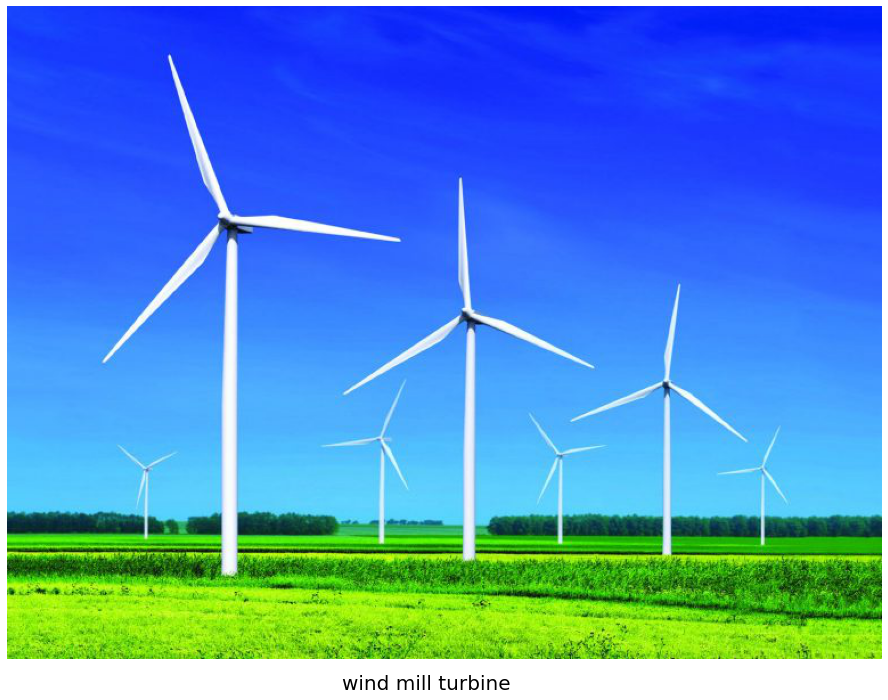

In [ ]:
imshow(image, caption)

## Get the predictions + the image with the bounding boxes

In [ ]:
annotated_image, top_predictions = glip_demo.run_on_web_image(image, caption, thresh=0.5, alpha = 0.5, color=250)

In [ ]:
labels = top_predictions.get_field("labels")
boxes = (top_predictions.bbox).to(torch.int64)
print(glip_demo.entities)
print(labels)
print(boxes)

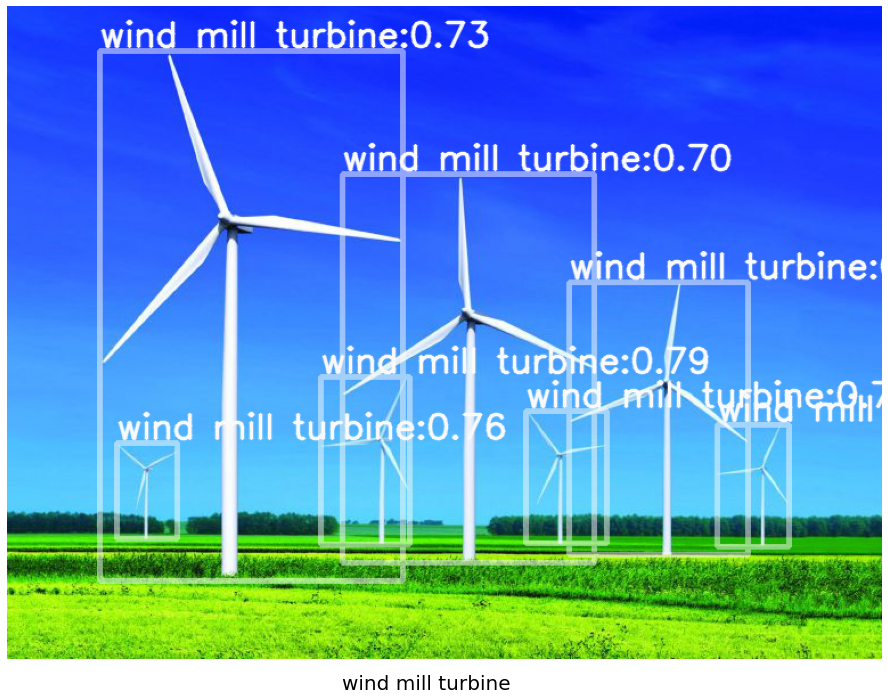

In [ ]:
imshow(annotated_image, caption)

In [ ]:
def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [ ]:
import pandas as pd

In [ ]:
def load_images(folder_path, caption):
  for i in os.listdir(folder_path):
    #load image and predict
    image = load(folder_path+'/'+i)
    print(i)
    annotated_image, top_predictions = glip_demo.run_on_web_image(image, caption, thresh=0.5, alpha = 0.5, color=250)
    labels = top_predictions.get_field("labels")
    boxes = (top_predictions.bbox).to(torch.int64)
    if torch.numel(labels) == 0 :
      continue
    else:
      _labels = pd.DataFrame(labels).astype("int")
      _boxes = pd.DataFrame(boxes).astype("int")
      label_boxes = pd.concat([_labels,_boxes], axis=1)
      label_boxes.columns = ["label","xmin","xmax", "ymin","ymax"]
      #save labels
      im=Image.open(folder_path+'/'+i)
      w= int(im.size[0])
      h= int(im.size[1])
      _yolo_box = []
      for ind in label_boxes.index:
        box = (label_boxes['xmin'][ind], label_boxes['ymin'][ind], label_boxes['xmax'][ind], label_boxes['ymax'][ind])
        yolo_box = convert((w,h), box)
        _yolo_box.append(yolo_box)
      _yolo_labels = pd.concat([_labels,  pd.DataFrame(_yolo_box).astype("float")], axis=1)
      np.savetxt('/content/drive/MyDrive/VTS/cleaver/label/'+i.split('.')[0]+ '.txt', _yolo_labels, fmt='%d %1.4f %1.4f %1.4f %1.4f')
      print(_yolo_labels)

In [ ]:
load_images('/content/drive/MyDrive/VTS/cleaver/image','cleaver')

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
   0    0         1        2         3
0  1  0.5  0.490826  0.92638  0.899083
TWKA29M2C4FL.jpg
[[[0, 7]]]
inference time per image: 0.6400046880007721
   0         0      1         2      3
0  1  0.539039  0.544  0.495495  0.904
MDUYCNTJL6OK.jpg
[[[0, 7]]]
inference time per image: 0.5824588989999029
   0      0         1      2         3
0  1  0.511  0.529333  0.838  0.674667
NL53N44L2OO7.jpg
[[[0, 7]]]
inference time per image: 0.6628272019997894
   0         0         1        2         3
0  1  0.496875  0.470874  0.90625  0.825243
1  1  0.665625  0.597087  0.56875  0.553398
2  1  0.243750  0.184466  0.38750  0.427184
T2SPG9IZ8ZK7.jpg
[[[0, 7]]]
inference time per image: 1.0470192579996365
   0        0      1         2     3
0  1  0.50000  0.500  0.938776  0.95
1  1  0.77551  0.600  0.408163  0.75
2  1  0.30102  0.375  0.581633  1.15
1N28Q2P0YN3J.jpg
[[[0, 7]]]
inference time per image: 0.5800223720007125
   0         0      